<a href="https://colab.research.google.com/github/Sahil01S/Amazon_data_segmentation/blob/main/amazon_customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
library(dplyr)
library(ggplot2)
library(corrplot)


In [ ]:
amazon = read.csv("amazon.csv", header=T)
names(amazon)
str(amazon)

[1] "product_id"          "product_name"        "category"           
 [4] "discounted_price"    "actual_price"        "discount_percentage"
 [7] "rating"              "rating_count"        "about_product"      
[10] "user_id"             "user_name"           "review_id"          
[13] "review_title"        "review_content"      "img_link"           
[16] "product_link"

'data.frame':	1465 obs. of  16 variables:
 $ product_id         : chr  "B07JW9H4J1" "B098NS6PVG" "B096MSW6CT" "B08HDJ86NZ" ...
 $ product_name       : chr  "Wayona Nylon Braided USB to Lightning Fast Charging and Data Sync Cable Compatible for iPhone 13, 12,11, X, 8, "| __truncated__ "Ambrane Unbreakable 60W / 3A Fast Charging 1.5m Braided Type C Cable for Smartphones, Tablets, Laptops & other "| __truncated__ "Sounce Fast Phone Charging Cable & Data Sync USB Cable Compatible for iPhone 13, 12,11, X, 8, 7, 6, 5, iPad Air"| __truncated__ "boAt Deuce USB 300 2 in 1 Type-C & Micro USB Stress Resistant, Tangle-Free, Sturdy Cable with 3A Fast Charging "| __truncated__ ...
 $ category           : chr  "Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables" "Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables" "Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables" "Computers&Accessories|Accessories&Peripher

In [ ]:

amazon$discounted_price <- as.numeric(gsub("₹|,", "", amazon$discounted_price))
amazon$actual_price <- as.numeric(gsub("₹|,", "", amazon$actual_price))
amazon$discount_percentage <- as.numeric(gsub("%", "", amazon$discount_percentage))
amazon$rating <- as.numeric(amazon$rating)
amazon$rating_count <- as.numeric(gsub(",", "", amazon$rating_count))
reviews <- amazon$review_content

colSums(is.na(amazon))



product_id        product_name            category    discounted_price 
                  0                   0                   0                   0 
       actual_price discount_percentage              rating        rating_count 
                  0                   0                   0                   0 
      about_product             user_id           user_name           review_id 
                  0                   0                   0                   0 
       review_title      review_content            img_link        product_link 
                  0                   0                   0                   0

In [ ]:

amazon <- na.omit(amazon)


                    discounted_price actual_price discount_percentage
discounted_price          1.00000000   0.96191037         -0.24229757
actual_price              0.96191037   1.00000000         -0.11785538
discount_percentage      -0.24229757  -0.11785538          1.00000000
rating                    0.12113188   0.12246744         -0.15567901
rating_count             -0.02730381  -0.03621549          0.01129439
                        rating rating_count
discounted_price     0.1211319  -0.02730381
actual_price         0.1224674  -0.03621549
discount_percentage -0.1556790   0.01129439
rating               1.0000000   0.10223482
rating_count         0.1022348   1.00000000


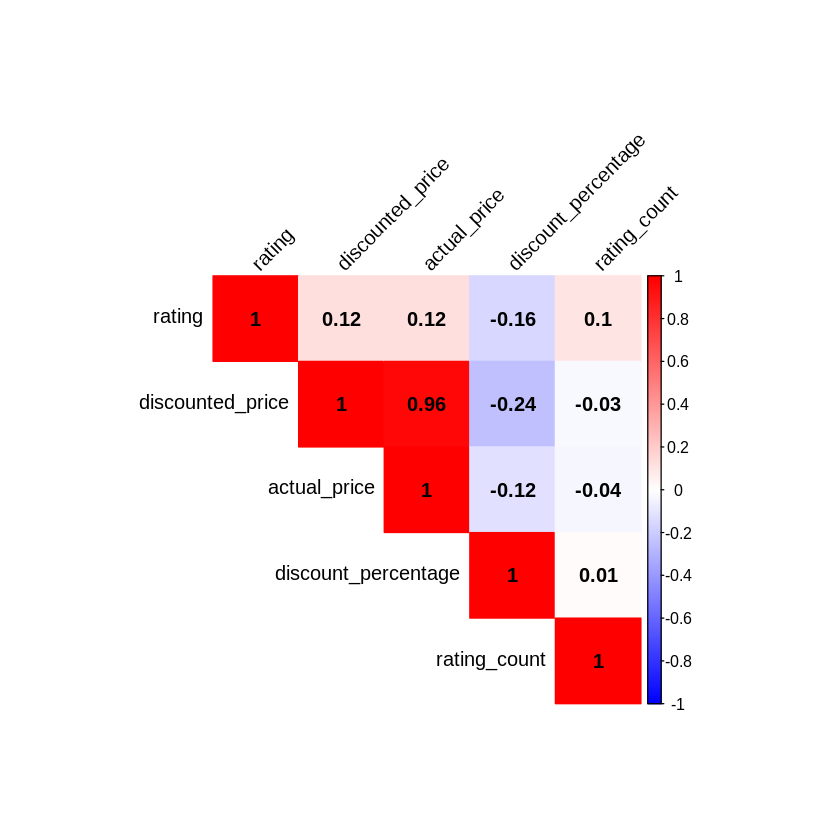

In [ ]:

# Correlation matrix
cor_matrix <- cor(amazon[, c("discounted_price", "actual_price", "discount_percentage", "rating", "rating_count")])
print(cor_matrix)

# Correlation plot
corrplot(cor_matrix, method = "color", type = "upper", order = "hclust",
         addCoef.col = "black", tl.col = "black", tl.srt = 45,
         col = colorRampPalette(c("blue", "white", "red"))(200))


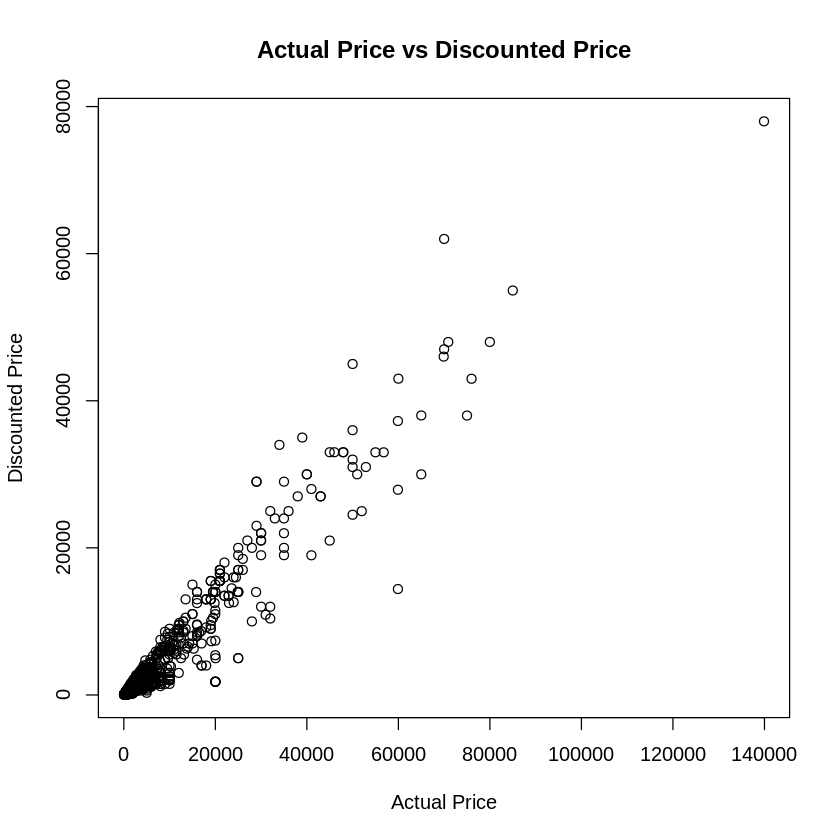

In [ ]:

plot(amazon$actual_price, amazon$discounted_price, main="Actual Price vs Discounted Price",
xlab="Actual Price", ylab="Discounted Price")



We can see from the correlation plot and the correlation matrix that there is no correlatiuon between any features except the actual price and discounted price, which are positively correlated (i.e. if actual price of any product increases/decreases, then the discounted price also increases/decreases.
```



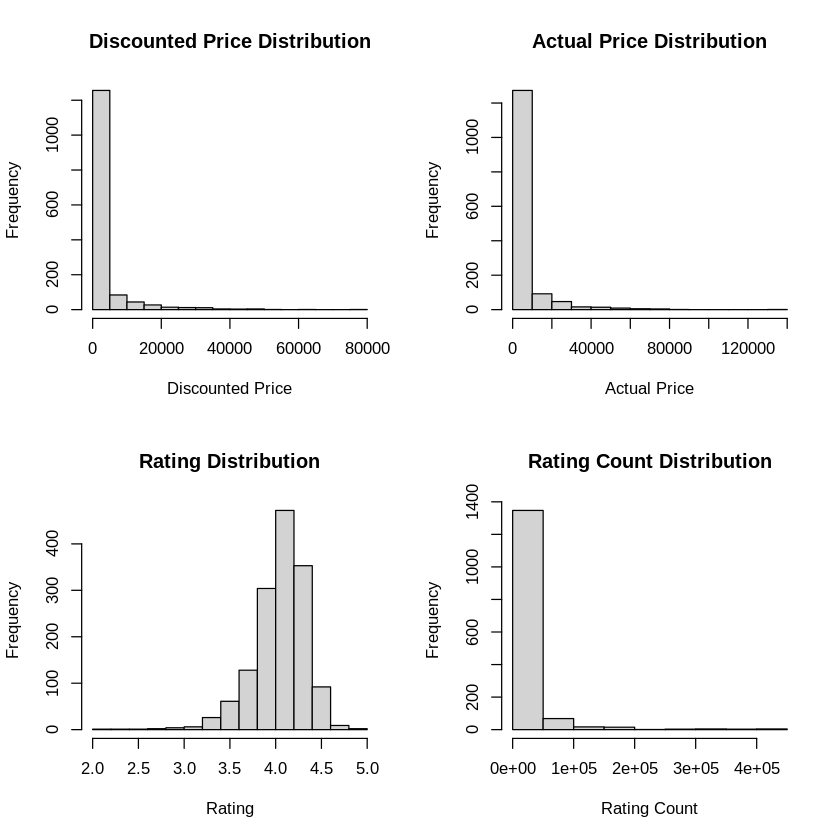

In [ ]:

par(mfrow=c(2,2))
hist(amazon$discounted_price, main="Discounted Price Distribution", xlab="Discounted Price")
hist(amazon$actual_price, main="Actual Price Distribution", xlab="Actual Price")
hist(amazon$rating, main="Rating Distribution", xlab="Rating")
hist(amazon$rating_count, main="Rating Count Distribution", xlab="Rating Count")
par(mfrow=c(1,1))


We also find that distribution of actual price, discounted price and rating count are positively skewed. The ratings are mostly distributed in the range between 3.5 and 4.5


**CUSTOMER SEGMENTATION ANALYSIS**


Now we will use k-means clusturing to perform customer segmentatiion.

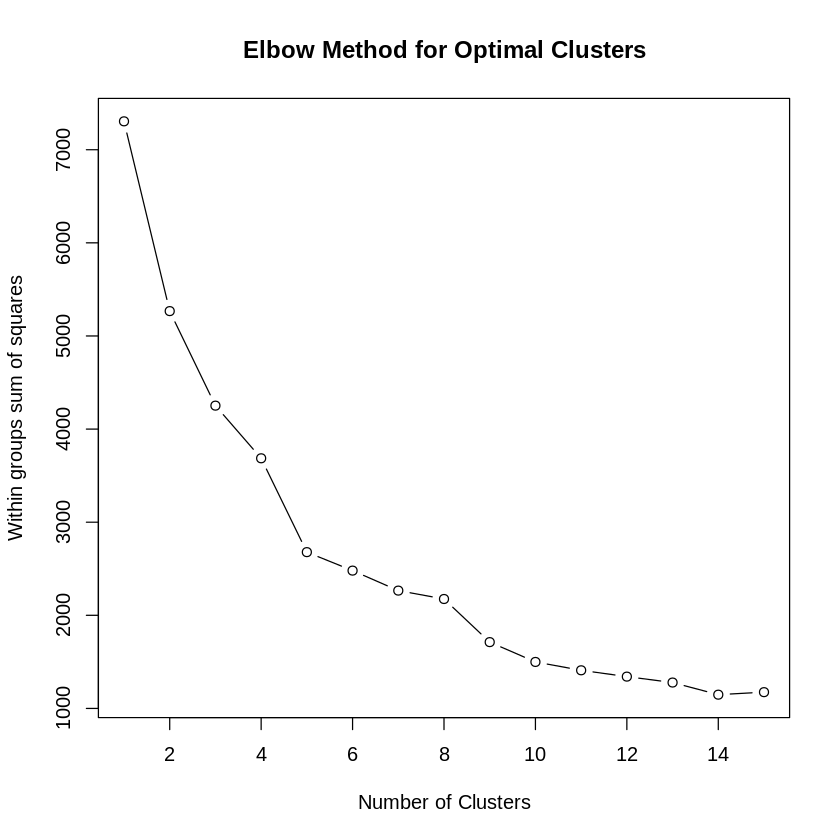

In [ ]:

amazon_cluster_data <- amazon[, c("discounted_price", "actual_price",
"discount_percentage", "rating", "rating_count")]
amazon_cluster_data <- scale(amazon_cluster_data)
set.seed(123)
wss <- (nrow(amazon_cluster_data)-1)*sum(apply(amazon_cluster_data, 2, var))
for (i in 2:15) wss[i] <- sum(kmeans(amazon_cluster_data, centers=i)$withinss)
plot(1:15, wss, type="b", main="Elbow Method for Optimal Clusters",
xlab="Number of Clusters", ylab="Within groups sum of squares")


We performed iteration with different values of k starting from 2 to 15 and we plot them against withing group sum of squares. From the graph, we can conclude that 5 is the optimal number of clusters since it appears at the bend in the elbow plot. So, we take k=5 here.

cluster,discounted_price,actual_price,discount_percentage,rating,rating_count
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1419.048,2410.167,47.45238,4.161905,221814.690
2,30972.283,47646.350,32.66667,4.230000,11451.400
3,1099.693,2634.565,58.25839,3.683557,7913.557
4,1029.178,2913.092,61.07729,4.214976,14240.968
5,3835.076,5483.619,23.70522,4.185034,12608.170


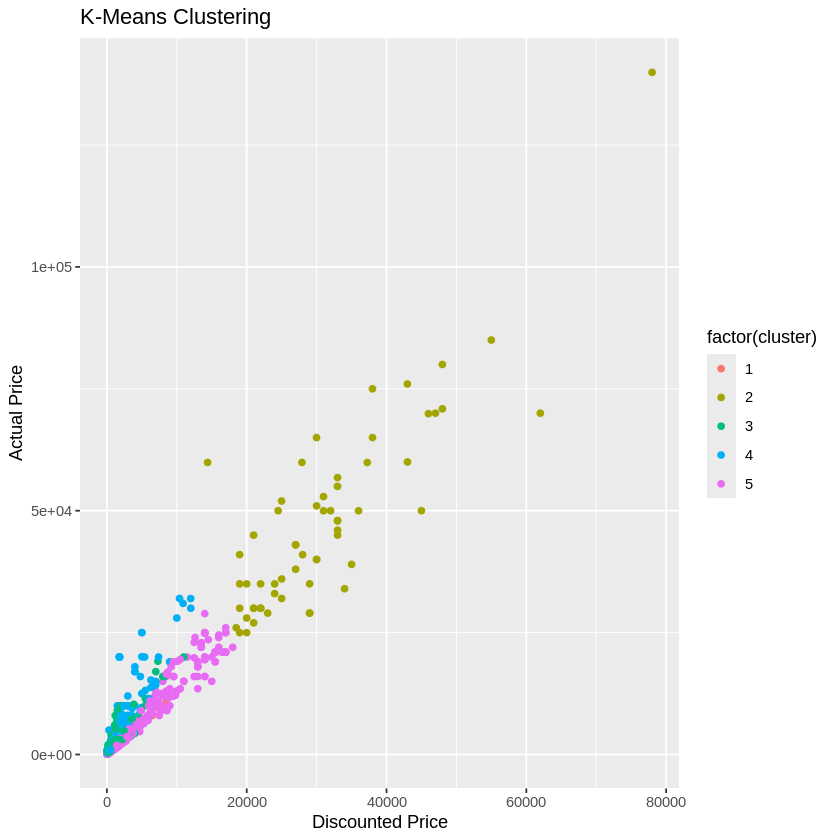

In [ ]:

set.seed(123)
k <- 5
kmeans_result <- kmeans(amazon_cluster_data, centers=k)
amazon$cluster <- kmeans_result$cluster

library(ggplot2)
ggplot(amazon, aes(x=discounted_price, y=actual_price, color=factor(cluster))) +
  geom_point() +
  labs(title="K-Means Clustering", x="Discounted Price", y="Actual Price")

 aggregate(amazon[, c("discounted_price", "actual_price", "discount_percentage", "rating", "rating_count")], by=list(cluster=amazon$cluster), mean)


We can find there is a distribution of five clusters. Cluster 3 and Cluster 4 have the highest average discount percentages (58.26% and 61.08%, respectively), which suggests that these clusters are characterized by high discounts. Cluster 4 has a slightly higher actual price but a significant discount percentage. Cluster 2 has the highest average actual price (₹47,646.35) and discounted price (₹30,972.28), indicating a premium segment with substantial discounts. Clusters 1, 4, and 5 have ratings around 4.16 to 4.21, suggesting a consistent quality across these clusters. Cluster 2 has the highest average rating (4.23), indicating that despite its higher prices, it maintains good customer ratings. Cluster 3 has the lowest average rating (3.68), which might indicate that products in this cluster have some issues or lower customer satisfaction. The scatter plot of discounted_price vs. actual_price with cluster coloring indicates the distribution of products across different price ranges and discounts. The clusters are spread out, showing distinct groups.


**CONCLUSION**

For products in Cluster 2, focusing on the premium market might be beneficial. Highlighting the high ratings and significant discounts could attract more buyers. For Cluster 3, investigating customer feedback and improving product quality or customer service could help enhance the ratings. For products in Clusters 1, 4, and 5, maintaining consistent pricing and discount strategies could help in sustaining their market position.